## Introduction
----
In this assignment, you will convert your batch least squares solution to a recursive one! Recall that you have the following data:

| Current (A) | Voltage (V) |
|-------------|-------------|
| 0.2         | 1.23        |
| 0.3         | 1.38        |
| 0.4         | 2.06        |
| 0.5         | 2.47        |
| 0.6         | 3.17        |

This time, you will be fitting a linear model which includes an offset, $y = Rx + b$. If Ohm's law ($V = RI$) holds, we expect this offset to be near zero.

You will set the initial parameters with the assumption that your prior estimate of the resistance $R = 4$ is not very good. Also, since you are fairly certain that Ohm's law ($V = RI$) does, in fact, hold, it is safe to assume with high confidence that the offset term $b$ will be close to zero. Initialize the estimator as follows:

$$\hat{R} \sim \mathcal{N}(4, 10.0), \hat{b} \sim \mathcal{N}(0, 0.2)$$

You can assume that we know the current perfectly, and that the voltage measurements are corrupted by additive, independent and identitically distributed Gaussian noise with variance $0.0225 ~ V^2$.

## Getting Started
----
As before, load the current and voltge measurements into numpy arrays and plot the values:

In [1]:
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt

I = np.array([0.2, 0.3, 0.4, 0.5, 0.6])
V = np.array([1.23, 1.38, 2.06, 2.47, 3.17])

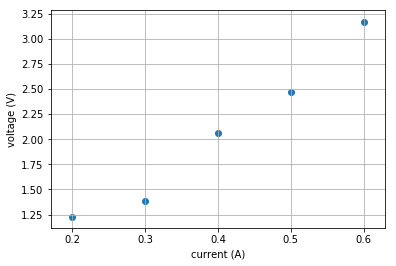

In [2]:
plt.scatter(I, V)

plt.xlabel('current (A)')
plt.ylabel('voltage (V)')
plt.grid(True)
plt.show()

## Estimating the Parameters
----
### Batch Estimator
Before implementing recursive least squares, let's review the parameter estimate given by the batch least squares method used in the previous assignment. This time, you will be fitting a model which contains an offset $y = Rx + b$. We can use this result later for comparison.

The parameters of the line fit are ([R, b]):
[4.97  0.074]


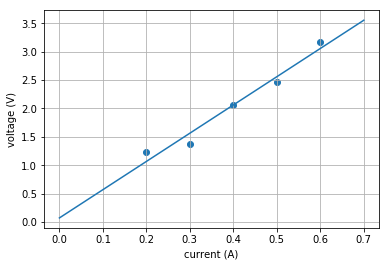

In [3]:
## Batch Solution
H = np.ones((5,2))
H[:, 0] = I
x_ls = inv(H.T.dot(H)).dot(H.T.dot(V))
print('The parameters of the line fit are ([R, b]):')
print(x_ls)

#Plot
I_line = np.arange(0, 0.8, 0.1)
V_line = x_ls[0]*I_line + x_ls[1]

plt.scatter(I, V)
plt.plot(I_line, V_line)
plt.xlabel('current (A)')
plt.ylabel('voltage (V)')
plt.grid(True)
plt.show()

As expected, the offset parameter $\hat{b}$ is near zero, while $\hat{R}$ closely approximates the true resistance value of $R = 5~\Omega$.

### Recursive Estimator
Now try to implement the least squares method recursively! Recall the steps described in Module 1, Lesson 2 - "Recursive Least Squares": 

**Initialize the parameter and covariance estimates**:

----
$$
\hat{\mathbf{x}}_0 = E\left[\mathbf{x}\right] \,\,\, , \,\,\, \mathbf{P}_0 = E\left[(\mathbf{x} - \hat{\mathbf{x}}_0)(\mathbf{x} - \hat{\mathbf{x}}_0)^T\right]
$$

**For every measurement k**:

----
  * Calculate the correction gain $$\mathbf{K}_k = \mathbf{P}_{k-1}\mathbf{H}_k^T\left(\mathbf{H}_k\mathbf{P}_{k-1}\mathbf{H}_k^T + \mathbf{R}_k\right)^{-1}$$
  * Update the parameter estimate $$\hat{\mathbf{x}}_k = \hat{\mathbf{x}}_{k-1} + \mathbf{K}_k\left(\mathbf{y}_k - \mathbf{H}_k\hat{\mathbf{x}}_{k-1}\right)$$
  * Update the covariance estimate $$\mathbf{P}_k = \left(\mathbf{I} - \mathbf{K}_k\mathbf{H}_k\right)\mathbf{P}_{k-1}$$

In [38]:
## Recursive solution

#Initialize the 2x2 covaraince matrix
P_k = np.zeros((2, 2))
P_k[0][0] = 100
P_k[1][1] = 0.04

#Initialize the parameter estimate x
x_k = np.zeros((2, 1))
x_k[0][0] = 4
x_k[1][0] = 0

V = V.reshape(num_meas, 1)
#Our measurement variance
Var = 0.0225

#Pre allocate our solutions so we can save the estimate at every step
num_meas = I.shape[0]
x_hist = np.zeros((num_meas + 1,2))
P_hist = np.zeros((num_meas + 1,2,2))

x_hist[0] = np.squeeze(x_k)
P_hist[0] = np.squeeze(P_k)

#Iterate over the measurements
for k in range(num_meas):
    #Construct H_k
    H = np.ones((num_meas, 2))
    H[:, 0] = I
  
    #Construct K_k
    K_k = P_k.dot(H.T).dot(np.linalg.inv(H.dot(P_k).dot(H.T) + Var * np.identity(num_meas)))
                    
    #Update our estimate

    
    
    x_k = x_k + K_k.dot(V - H.dot(x_k))
        

    #Update our uncertainty
    P_k = (np.identity(2) - K_k.dot(H)).dot(P_k)

    #Keep track of our history
    
    P_hist[k+1] = np.squeeze(P_k)
    x_hist[k+1] = np.squeeze(x_k)
    
print('The parameters of the line fit are ([R, b]):')
print(x_k)

The parameters of the line fit are ([R, b]):
[[4.9973107 ]
 [0.06168775]]


## Plotting the Results
----
Let's plot out the solutions at every step. Does the value converge towards the batch least squares solution from the previous assignment?

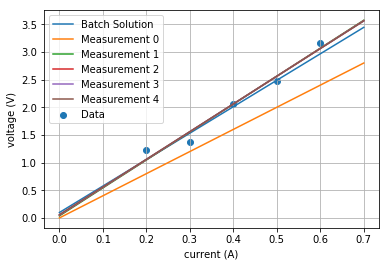

In [40]:
#Plot
plt.scatter(I, V, label='Data')
plt.plot(I_line, V_line, label='Batch Solution')
plt.xlabel('current (A)')
plt.ylabel('voltage (V)')
plt.grid(True)

I_line = np.arange(0, 0.8, 0.1)
for k in range(0, num_meas):
    V_line = x_hist[k,0]*I_line + x_hist[k,1]
    plt.plot(I_line, V_line, label='Measurement {}'.format(k))

plt.legend()
plt.show()

The resistance estimate does approach the true resistance value of $R = 5~\Omega$. Try modifying the initialization values (e.g., the intial uncertainty) - can you get a better final estimate?